In [87]:
# Initialize Otter
import otter
grader = otter.Notebook("hw08.ipynb")

<a id="top"></a>

# Homework 8: IMDb

We will use SQL to dive deep into the Internet Movie Database (IMDb) and answer different questions involving movies, actors, and movie ratings.
## Due Date: Thursday, November 9th, 11:59 PM

You must submit this assignment to Gradescope by the on-time deadline, Thursday, November 9th, 11:59 PM. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted. **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to reach out to staff for support if you encounter difficulties with submission. While course staff is happy to help guide you with submitting your assignment ahead of the deadline, we will not respond to last-minute requests for assistance (TAs need to sleep, after all!).

Please read the instructions carefully to submit your work to both the coding and written portals of Gradescope.


##  Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** below.

**Collaborators**: *list collaborators here*

## Grading 

Grading is broken down into autograded answers and free response. For autograded answers, the results of your code are compared to provided and/or hidden tests. For free response, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question.

<!--
<details>
    <summary>[Click to Expand] <b>Scoring Breakdown</b></summary>-->
|Question| Manual | Points|
|---|---|---|
|1a | No | 2 |
|1b | No | 2 |
|2 | No | 3 |
|3 | No | 3 |
|4a | No | 4 |
|4b | Yes | 2 |
|5 | No | 4 |
|Total | 1 |20 |
</details>

After running the cell below, you may be prompted to upgrade `jupysql` using `pip`. You do not need to worry about that, no additional cells need to be added by you for this setup.

In [88]:
# Run this cell to set up your notebook; no further action is needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sqlalchemy

plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
np.set_printoptions(threshold=5) # Avoid printing out big matrices
%matplotlib inline
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## The IMDB (mini) Dataset


We will explore a miniature version of the [IMDb Dataset](https://www.imdb.com/interfaces/). This is the same dataset that we used for this week's lab. The remainder of this overview section is copied from this week's lab.

* **Caution: Be careful with large SQL queries!!** You may need to reboot your Jupyter Hub instance if it stops responding. To avoid printing out 100k-sized tables, **use the LIMIT keyword** (but remember to remove it if not needed).

Let's load the database in two ways (using both `Python` and cell magic) so that we can flexibly explore the SQL database.

In [89]:
# Run this cell to set up the autograder
from sql_utils import * 
from pathlib import Path
Path("results").mkdir(parents=True, exist_ok=True)

# These lines specify the location of our database file
dbfile = 'imdbmini.db'
tmpdb = Path('data') / dbfile

# Specify the database connection path (in this case, a sqlite database in a file)
sqlite_conn = 'sqlite:///' + str(tmpdb)

In [90]:
# Run this cell to connect to database
engine = sqlalchemy.create_engine(sqlite_conn)
connection = engine.connect()

In [91]:
%sql engine

Let's take a look at the table schemas:

In [92]:
%%sql
-- just run this cell --
SELECT * FROM sqlite_master WHERE type='table';

Running query in 'sqlite:///data/imdbmini.db'

type,name,tbl_name,rootpage,sql
table,Title,Title,2,"CREATE TABLE ""Title"" (""tconst"" INTEGER, ""titleType"" TEXT, ""primaryTitle"" TEXT, ""originalTitle"" TEXT, ""isAdult"" TEXT, ""startYear"" TEXT, ""endYear"" TEXT, ""runtimeMinutes"" TEXT, ""genres"" TEXT)"
table,Name,Name,12,"CREATE TABLE ""Name"" (""nconst"" INTEGER, ""primaryName"" TEXT, ""birthYear"" TEXT, ""deathYear"" TEXT, ""primaryProfession"" TEXT)"
table,Role,Role,70,"CREATE TABLE ""Role"" (tconst INTEGER,ordering TEXT,nconst INTEGER,category TEXT,job TEXT,characters TEXT)"
table,Rating,Rating,41,"CREATE TABLE ""Rating"" (tconst INTEGER,averageRating TEXT,numVotes TEXT)"


From running the above cell, we see the database has 4 tables: `Name`, `Role`, `Rating`, and `Title`.

<details open>
    <summary>[<b>Click to Expand</b>] See descriptions of each table's schema. We have only included descriptions for columns that could be of potential use in this homework. </summary>
    
**`Name`** – Contains the following information for names of people.
    
- nconst (integer) - alphanumeric unique identifier of the name/person
- primaryName (text) - name by which the person is most often credited
- birthYear (text) - in YYYY format
- deathYear (text) - in YYYY format
    
    
**`Role`** – Contains the principal cast/crew for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- ordering (text) - a number to uniquely identify rows for a given tconst
- nconst (integer) - alphanumeric unique identifier of the name/person
- category (text) - the category of job that person was in
- characters (text) - the name of the character played if applicable, else '\\N'
    
**`Rating`** – Contains the IMDb rating and vote information for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- averageRating (text) – weighted average of all the individual user ratings
- numVotes (text) - number of votes (i.e., ratings) the title has received
    
**`Title`** - Contains the following information for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- titleType (text) -  the type/format of the title
- primaryTitle (text) -  the more popular title / the title used by the producers on promotional materials at the point of release
- isAdult (text) - 0: non-adult title; 1: adult title
- startYear (text) - represents the release year of a title.
- runtimeMinutes (text) - primary runtime of the title, in minutes
    
</details>

<br/><br/>
From the above descriptions, we can conclude the following:
* `Name.nconst` and `Title.tconst` are primary keys of the `Name` and `Title` tables, respectively.
* `Role.nconst` and `Role.tconst` are **foreign keys** that point to `Name.nconst` and `Title.tconst`, respectively.

For a refresher on how to write SQL queries in Jupyter, feel free to reference the start of Lab 10. The main thing to keep in mind is that you can directly write your query in place of the ellipsis under `%%sql --save query_q res_q`. 

<br/><br/>

---

### Question 1a
How far back does our data go? Does it only include recent data, or do we have information about older movies and movie stars as well? 

List the **10 oldest movie titles**  by `startYear` and then `primaryTitle` both in **ascending** order. The output should contain the `startYear`, `primaryTitle`, and `titleType`. In this homework, we define a movie as having `titleType='movie'`. Keep this in mind for later questions as well.

In [93]:
%%sql --save query_q1a res_q1a <<
SELECT startYear, primaryTitle, titleType
    FROM Title
    WHERE titleType = 'movie' AND startYear IS NOT NULL
ORDER BY startYear, primaryTitle
LIMIT 10;

Running query in 'sqlite:///data/imdbmini.db'

In [94]:
# Run this cell before running the autograder; no further action is needed
query_q1a = %sqlcmd snippets query_q1a
save_results("res_q1a", query_q1a, res_q1a)
res_q1a

startYear,primaryTitle,titleType
1915,The Birth of a Nation,movie
1920,The Cabinet of Dr. Caligari,movie
1921,The Kid,movie
1922,Nosferatu,movie
1924,Sherlock Jr.,movie
1925,Battleship Potemkin,movie
1925,The Gold Rush,movie
1926,The General,movie
1927,Metropolis,movie
1927,Sunrise,movie


In [95]:
grader.check("q1a")

q1a results: All test cases passed!

<br/><br/>

---

### Question 1b

Next, let's calculate the distribution of movies by year. Write a query that returns the **total** number of movie titles for each `startYear` in the `Title` table as `total`.  Keep in mind that some entries may not have a `startYear` listed -- you should filter those out.  Order your final results by the `startYear` in **ascending** order. As in `q1a`, remember that movies are defined as having `titleType=’movie’`.

The first few records of the table should look like the following (but you should compute the entire table).


|startYear|total|
|------:|-----:|
| 1915|1|
| 1920|1|
| 1921|1|
| 1922|1|
| ...|...|



In [96]:
%%sql --save query_q1b res_q1b <<
SELECT startYear, COUNT(*) AS total
    FROM Title
WHERE titleType = 'movie' AND startYear IS NOT NULL
GROUP BY startYear
ORDER BY startYear;   

Running query in 'sqlite:///data/imdbmini.db'

In [97]:
# Run this cell before running the autograder; no further action is needed
query_q1b = %sqlcmd snippets query_q1b
save_results("res_q1b", query_q1b, res_q1b)
res_q1b

startYear,total
1915,1
1920,1
1921,1
1922,1
1924,1
1925,2
1926,1
1927,2
1928,2
1929,1


In [98]:
grader.check("q1b")

q1b results: All test cases passed!

<br/><br/>

The following cell should generate an interesting plot of the number of movies that premiered each year. Notice there are fewer movies premiering from the 1920s to the late 1940s. Why might that be? *This question is rhetorical; you do not need to write your answer anywhere.*

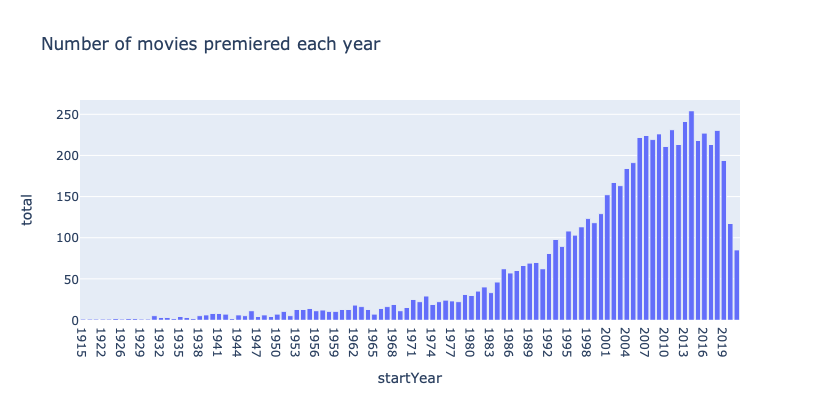

In [99]:
# Run this call to generate the bar plot; no further action is needed
px.bar(res_q1b, x="startYear", y="total", title="Number of movies premiered each year", width=900, height=400)

<br/><br/>

---

## Question 2

Who are the **top 10 most prolific movie actors**?

The term **"movie actor"** is defined as anyone with an `"actor"` or `"actress"` job category role in a `"movie"` title type.

Your SQL query should output exactly two fields named `name` (the movie actor's name) and `total` (the number of movies the movie actor appears in). Order the records by `total` in descending order, and break ties by ordering by `name` in ascending order.

Your result should look something like the following, but without `????`:

| name | total |
|-----:|-----:|
| ???? | 64 |
| ???? | 54 |
| ???? | 53 |
| ???? | 49 |
| ???? | 46 |
| ???? | 43 |
| ???? | 41 |
| ???? | 40 |
| ???? | 40 |
| ???? | 39 |

**Hints**:

* ***The query should take < 2 minutes to run.***
* Before writing your query, you may wish to review the table descriptions given at the start of the assignment to determine where the information you need is stored
* If you want to include a non-aggregate field in the `SELECT` clause, it must also be included in the `GROUP BY` clause.
* When using multiple conditions in a `WHERE` clause, pay attention to the order of operations.

In [100]:
%%sql --save query_q2 res_q2 <<
SELECT Name.primaryName AS name, COUNT(*) AS total
    FROM Name
JOIN Role ON Name.nconst = Role.nconst
JOIN Title on Role.tconst = Title.tconst
WHERE Title.titleType = 'movie' AND
    Role.category IN ('actor', 'actress')
GROUP BY Name.primaryName
ORDER BY total DESC, name ASC
LIMIT 10;

Running query in 'sqlite:///data/imdbmini.db'

In [101]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_q2 = %sqlcmd snippets query_q2
save_results("res_q2", query_q2, res_q2)
res_q2

name,total
Robert De Niro,64
Samuel L. Jackson,54
Nicolas Cage,53
Bruce Willis,49
Tom Hanks,46
Johnny Depp,43
Mark Wahlberg,41
Liam Neeson,40
Morgan Freeman,40
Adam Sandler,39


In [102]:
grader.check("q2")

q2 results: All test cases passed!

<br/><br/>

---

## Question 3: The `CASE` Keyword

The `Rating` table has the `numVotes` and the `averageRating` for each title. A movie is considered a **"big hit**" if there are more than 100,000 votes for the movie. Which `movie` titles were **"big hits"**? Construct a query that generates the following result:

| isBigHit | total |
|-----:|-----|
| no | ???? |
| yes | ???? |

Where `????` is replaced with the correct values. The row with `no` should have the count for how many movies **are not** big hits, and the row with `yes` should have the count of how many movies **are** big hits.

**Hints**:

* While SQL sometimes casts data automatically, it is still best practice to cast string data to a numerical data type manually before performing arithmetic operations for the purposes of readability and reproducibility.
* You will need to use some type of `JOIN`.
* You may also consider using a `CASE` statement:
    ```
    CASE 
        WHEN ... THEN ...
        ELSE ... 
    END
    ```
 `CASE` statements are the SQL equivalent of `Python` `if... elif... else` statements. To read up on `CASE`, take a look at the following links:
    - https://mode.com/sql-tutorial/sql-case/
    - https://www.w3schools.com/sql/sql_ref_case.asp


In [103]:
%%sql --save query_q3 res_q3 <<
SELECT CASE 
    WHEN CAST(Rating.numVotes AS INT) > 100000 THEN 'yes'
    ELSE 'no'
    END AS isBigHit,
    COUNT(*) AS total
FROM Title
JOIN Rating ON Rating.tconst = Title.tconst
WHERE Title.titleType = 'movie'
GROUP BY isBigHit;

Running query in 'sqlite:///data/imdbmini.db'

In [104]:
# Run this cell before running the autograder; no further action is needed
query_q3 = %sqlcmd snippets query_q3
save_results("res_q3", query_q3, res_q3)
res_q3

isBigHit,total
no,4318
yes,2041


In [105]:
grader.check("q3")

q3 results: All test cases passed!

<br/><br/>

---

## Question 4

**How does movie length relate to ratings?**  To answer this question we want to bin `movie` titles by length, compute the average of the average ratings within each length bin, and visualize the relations.

### Question 4a

We will group movies by 10-minute increments -- that is, one bin for movies \[0, 10) minutes long, another for \[10, 20) minutes, another for \[20, 30) minutes, and so on. Use the following code snippet to help construct 10-minute bins: 

```
ROUND(runtimeMinutes / 10.0 + 0.5) * 10 AS runtimeBin
```

Construct a query that generates a resulting table containing the **`runtimeBin`**, the **average** of the **average ratings** (as `averageRating`), the **average number of votes** (as `averageNumVotes`), and the number of `titles` in that **runtimeBin** (as `total`).  Only include movies with **at least 8000 votes**.  Order the final results by the value of `runtimeBin` in ascending order.

**Hint**:
* You can use a variable(s) defined in your `SELECT` clause in the later part of your query.

In [106]:
%%sql --save query_q4 res_q4 <<
SELECT ROUND(runtimeMinutes / 10.0 + 0.5) * 10 AS runtimeBin,
AVG(averageRating) AS averageRating,
AVG(numVotes) AS averageNumVotes,
COUNT(*) AS total
FROM Title
JOIN Rating
ON Title.tconst = Rating.tconst
WHERE Rating.numVotes >= 8000
AND Title.titleType = 'movie'
GROUP BY runtimeBin
ORDER BY runtimeBin;

Running query in 'sqlite:///data/imdbmini.db'

In [107]:
# Run this cell before running the autograder; no further action is needed
query_q4 = %sqlcmd snippets query_q4
save_results("res_q4", query_q4, res_q4)
res_q4

runtimeBin,averageRating,averageNumVotes,total
70.0,7.666666666666667,86905.33333333333,3
80.0,7.15,95755.0,2
90.0,6.3088235294117645,139127.0,34
100.0,6.522834645669291,108610.44881889764,127
110.0,6.677477477477478,141948.45945945947,111
120.0,6.619736842105263,108717.40789473684,76
130.0,7.143548387096774,170554.48387096773,62
140.0,6.921212121212122,234249.30303030304,33
150.0,7.315789473684211,304101.84210526315,19
160.0,7.840000000000001,92310.0,5


In [108]:
grader.check("q4a")

q4a results: All test cases passed!

<br><br>

Let us take a look at the current distribution of movie runtimes.

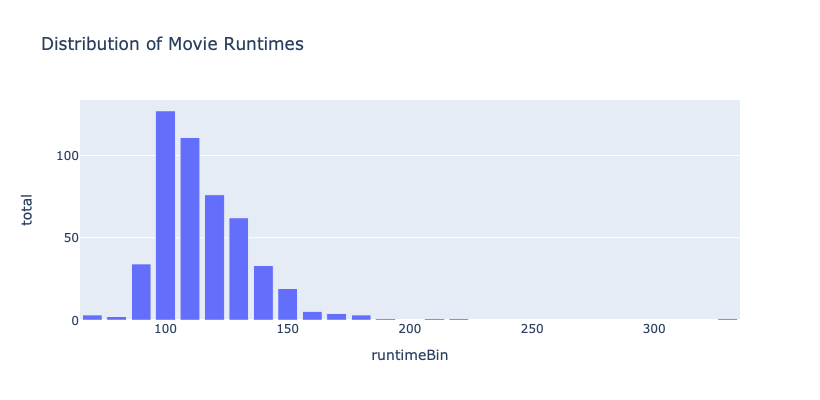

In [109]:
# Run the cell below; no further action is needed
query_q4, res_q4 = load_results('res_q4')
px.bar(res_q4, x="runtimeBin", y="total", title="Distribution of Movie Runtimes", width = 800, height = 400)

<!-- BEGIN QUESTION -->

<br><br>

---

### Question 4b

Create two line plots below. The first should show the relationship between average number of votes and runtime; the second should show the relationship between average rating and runtime. The runtime should be on the x-axis for both plots. Use the columns from the table generated in the previous part, `res_q4`. If your SQL query is correct you should get some interesting plots below. This might explain why directors keep going with a particular range of runtimes. 

**Note**:
Please use `sns` or `plt` functions for plotting. Plotly `px` does not export to the PDF properly. Please include descriptive titles and labels. If your plot does not show on the generated PDF, please upload a PDF with a screenshot of your code and the plot.

Text(0.5, 1.0, 'Average Ratings for Movies vs. Run Time')

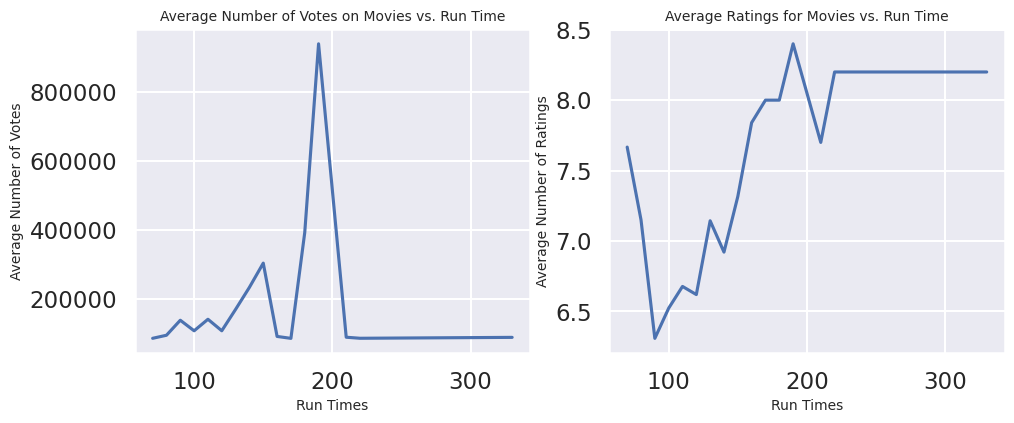

In [110]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1) # DO NOT MODIFY THIS LINE
plt.plot(res_q4["runtimeBin"], res_q4["averageNumVotes"])
plt.xlabel("Run Times", fontsize = 10)
plt.ylabel("Average Number of Votes", fontsize = 10)
plt.title("Average Number of Votes on Movies vs. Run Time", fontsize = 10)
plt.subplot(1, 2, 2) # DO NOT MODIFY THIS LINE
plt.plot(res_q4["runtimeBin"], res_q4["averageRating"])
plt.xlabel("Run Times", fontsize = 10)
plt.ylabel("Average Number of Ratings", fontsize = 10)
plt.title("Average Ratings for Movies vs. Run Time", fontsize = 10)

<!-- END QUESTION -->

<br/><br/>

---

## Question 5


Which **movie actors** have the highest average ratings across all the movies in which they star? Again, define **"movie actor"** as anyone with an `actor` or `actress` job category role in a `movie` title type.

Construct a query that generates a resulting table consisting of the **movie actor's name**  (as `name`) and their **average actor rating** (as `actorRating`) computed by rescaling ratings for movies in which they had a role:

$$
\text{actorRating} = 
\frac{\sum_m (\text{averageRating}[m] * \text{numVotes}[m] )}{\sum_m \text{numVotes}[m]}
$$

In addition, only consider ratings where there are **at least 1000** votes and only consider movie actors that have **at least 20 rated performances**. Present the movie actors with the **top 10** `actorRating` in descending order and break ties alphabetically using the movie actor's name.

**Note:** DO NOT cast `averageRating` **as an integer**. Doing so reduces the precision of the resulting values, so your table may not match up exactly with what is shown below.

The results should look something like this but without the `????`, and with higher rating precision.

| name | actorRating |
|-----:|:-----|
|????|8.4413...|
|????|8.2473...|
|????|8.1383...|
|????|8.1339...|
|????|8.0349...|
|????|7.9898...|
|????|7.9464...|
|????|7.9330...|
|????|7.9261...|
|????|7.8668...|


**Note**:
* ***The query should take < 3 minutes to run.***
* If an actor/actress has multiple `role` listings for a movie, then that movie will have a bigger impact on the overall average (this is desired).

In [111]:
%%sql --save query_q5 res_q5 <<
SELECT Name.primaryName AS name, 
    (SUM(Rating.averageRating * Rating.numVotes)/SUM(Rating.numVotes)) AS actorRating
FROM Name
JOIN Role ON Name.nconst == Role.nconst
JOIN Title ON Role.tconst == Title.tconst
JOIN Rating on Rating.tconst == Title.tconst 
WHERE Title.titleType = 'movie' AND
    Role.category IN ('actor', 'actress')
AND Rating.numVotes >= 1000
GROUP BY Name.nconst, name HAVING COUNT(*) >= 20
ORDER BY actorRating DESC, name ASC
LIMIT 10;


Running query in 'sqlite:///data/imdbmini.db'

In [112]:
# Run this cell before running the autograder; no further action is needed
query_q5 = %sqlcmd snippets query_q5
save_results("res_q5", query_q5, res_q5)
res_q5

name,actorRating
Diane Keaton,8.441302223858012
Tim Robbins,8.247318384970836
Al Pacino,8.138361195580252
Michael Caine,8.13391512838329
Leonardo DiCaprio,8.034960968967019
Christian Bale,7.989825204141808
Robert Duvall,7.946482669218899
Jack Nicholson,7.933033651440138
Kevin Spacey,7.926157790005812
Clint Eastwood,7.866838521067401


In [113]:
grader.check("q5")

q5 results: All test cases passed!

<br><br>


<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Pretzel congratulates you for finishing Homework 8!

<img src="pretzel.jpg" width="500px"/> 

**You are responsible for both the coding portion (the zip from Homework 8) and the written portion (the PDF from Homework 8) to their respective Gradescope portals.** The coding proportion should be submitted to Homework 8 Coding as a single zip file, and the written portion should be submitted to Homework 8 Written as a single PDF file. When submitting the written portion, please ensure you select pages appropriately and check all plots appear. 

If there are issues with opening the PDF, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. **You are responsible for ensuring your submission follows our requirements.**


## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

After you have run the cell below and generated the zip file, you can open the PDF <a href='hw08.pdf' download>here</a>.

In [114]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True, files=['results'])

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q1a results: All test cases passed!

    q1b results: All test cases passed!

    q2 results: All test cases passed!

    q3 results: All test cases passed!

    q4a results: All test cases passed!

    q5 results: All test cases passed!
